In [1]:
# Source: 
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with
# %20Neural%20Networks.ipynb

In [5]:
import os
from IPython.display import Image

pth = os.getcwd() # where we started jupyter-notebook
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 1 - Sequence to Sequence Learning with Neural Networks

In this series we'll be building a machine learning model to go from once sequence to another, using PyTorch and TorchText. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization.

In this first notebook, we'll start simple to understand the general concepts by implementing the model from the Sequence to [Sequence Learning with Neural Networks paper](https://arxiv.org/pdf/1409.3215.pdf).


### Introduction

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector. 
We'll refer to this single vector as a context vector. The context vector is an abstract representation of the entire input sentence. 
This context vector will be decoded by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

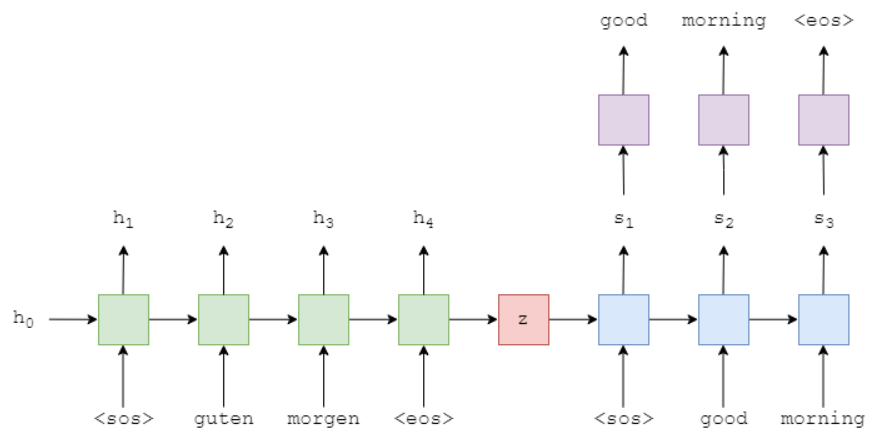

In [6]:
Image(filename= pth + "/images/rnn_translation.png")

An example translation is above: 

The input sentence "guten morgen" is input into the encoder (green boxes) one word at a time. 
We also append a *start of sequence* `<sos>` to the start of the sentence and *end of sequence* `<eos>` token to the end of the sentence. 

At each time-step, the input to the encoder RNN is both the current word $x_t$ and the hidden state $h_{t-1}$ from the previous time step, and the encoder RNN uses these to output a new hidden state $h_t$. 

The RNN's hidden state $h_t$ is a vector representation of the sentence so far (memory). The RNN can be represented as a function of both $x_t$ and $ h_{t-1} $: 
$$
h_t = EncoderRNN(x_t, h_{t-1})
$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an LSTM (Long Short-Term Memory) or a GRU (Gated Recurrent Unit).

##### Variable Meanings: 

The inputs are: 

\begin{array}{ll}
X = \{x_1, x_2, ..., x_T\} \\
x_1 = \text{<sos>} \\
x_2 = \text{guten} \\
x_3 = \text{morgen} \\
x_4 = \text{<eos>} \\
\end{array}

The hidden states are: 

\begin{array}{ll}
h_0 = \text{initial hidden state and is usually initialized to zeros or a learned parameter.} \\
h_i = \text{resulting hidden states, for all} i \\
\end{array}

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)

# note about reproducibility in CUDA: 
# https://hyp.is/dOiOAAuzEeqcu2OxIZfR4w/pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True 

In [4]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

In [ ]:
# Creating the tokenizer functions
# NOTE: reversing due to optimization ease

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    and reverses it
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)][::-1]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

In [ ]:

# German = source language, English = target language

SRC = Field(tokenize = tokenizeGerman, 
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)